In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
df = pd.read_csv('df_fixed.csv')

df.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,1,6,1209,1,3,2,2,2,6,2.0833,1,5335
1,2023-01-16,1,5,164,1,3,2,2,3,6,2.3333,1,5899
2,2023-01-16,1,4,942,1,3,2,2,3,6,2.1667,1,5801
3,2023-01-16,1,6,1224,1,3,2,2,2,6,2.0833,1,5794
4,2023-01-16,1,0,852,1,3,2,2,2,6,2.1667,1,5955


In [3]:
from sklearn.model_selection import train_test_split

df['Date_of_journey'] = pd.to_datetime(df['Date_of_journey'])
df.sort_values(by='Date_of_journey')

df['year'] = df['Date_of_journey'].dt.year
df['month'] = df['Date_of_journey'].dt.month
df['day'] = df['Date_of_journey'].dt.day

df = df.drop(['Date_of_journey','Flight_code'],axis=1)

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

df['Duration_in_hours'] = scaler.fit_transform(df[['Duration_in_hours']])
df['Days_left'] = scaler.fit_transform(df[['Days_left']])


'''X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42)

X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

X_train'''

c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

'X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42)\n\nX_train=pd.DataFrame(X_train)\nX_test=pd.DataFrame(X_test)\n\nX_train'

In [4]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class FlightFareDataset(Dataset):
    def __init__(self, df, sequence_length=10):
        self.sequence_length = sequence_length
        features = df.drop(columns=['Fare']).values
        target = df['Fare'].values
        
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.sequence_length]
        y = self.target[idx + self.sequence_length]
        return x, y

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Load your DataFrame (assuming it's stored in a CSV file or similar)

# Normalize the features and target
scaler = MinMaxScaler()
df[df.columns.difference(['Fare'])] = scaler.fit_transform(df[df.columns.difference(['Fare'])])
df['Fare'] = scaler.fit_transform(df[['Fare']])

# Create an instance of the dataset
sequence_length = 20  # Adjust as needed
dataset = FlightFareDataset(df, sequence_length)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define model parameters
input_size = df.shape[1] - 1  # Number of features
hidden_size = 50  # Number of features in the hidden state
num_layers = 4  # Number of recurrent layers
output_size = 1  # Single output for 'Fare'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model with validation
'''num_epochs = 40  # Adjust as needed
checkpoint_dir = 'checkpoints'  # Directory to save checkpoints
os.makedirs(checkpoint_dir, exist_ok=True)


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)
        target = target.to(device).unsqueeze(1)
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)
        train_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, target in val_loader:
            features = features.to(device)
            target = target.to(device).unsqueeze(1)
            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Model checkpoint saved at {checkpoint_path}')

# Make predictions (example with a single batch)
model.eval()
with torch.no_grad():
    for features, target in val_loader:
        features = features.to(device)
        target = target.to(device).unsqueeze(1)
        
        predictions = model(features)
        print(predictions)
        break  # Remove this break to iterate over all batches'''


c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

"num_epochs = 40  # Adjust as needed\ncheckpoint_dir = 'checkpoints'  # Directory to save checkpoints\nos.makedirs(checkpoint_dir, exist_ok=True)\n\n\nfor epoch in range(num_epochs):\n    model.train()\n    train_loss = 0.0\n    for i, (features, target) in enumerate(train_loader):\n        features = features.to(device)\n        target = target.to(device).unsqueeze(1)\n        \n        # Forward pass\n        outputs = model(features)\n        loss = criterion(outputs, target)\n        train_loss += loss.item()\n        \n        # Backward pass and optimization\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n        \n    # Validation\n    model.eval()\n    val_loss = 0.0\n    with torch.no_grad():\n        for features, target in val_loader:\n            features = features.to(device)\n            target = target.to(device).unsqueeze(1)\n            outputs = model(features)\n            loss = criterion(outputs, target)\n            val_loss += l

In [5]:
checkpoint_path = 'checkpoints/model_epoch_35.pth'

# Load the saved state dictionary from the checkpoint
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)

# Set the model to evaluation mode
model.eval()

print(f'Model loaded from {checkpoint_path}')

Model loaded from checkpoints/model_epoch_35.pth


In [6]:
split_index = int(len(df) * 0.9)

# Get the last 20% of the dataset
test_df = df.iloc[split_index:]

test_dataset = FlightFareDataset(test_df, sequence_length=10)  # Adjust sequence_length if needed

batch_size = 32  # Adjust batch size if needed
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Ensure that CUDA is available and select the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Switch model to evaluation mode and move it to the appropriate device
model.eval()
model.to(device)

# Initialize variables to store predictions and targets
all_predictions = []
all_targets = []

# Disable gradients during inference
with torch.no_grad():
    for features, targets in test_loader:
        features = features.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(features)
        
        # Store predictions and targets
        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate evaluation metrics
mse = np.mean((all_predictions - all_targets) ** 2)
mae = np.mean(np.abs(all_predictions - all_targets))

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')


Mean Squared Error (MSE): 0.0343
Mean Absolute Error (MAE): 0.1356


In [7]:
test_df.head()

,Journey_day,Airline,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare,year,month,day
396078,1.0,1.0,1.0,0.333333,0.333333,0.0,0.666667,0.0,0.217898,0.897959,0.094375,0.0,1.0,0.0
396079,1.0,1.0,1.0,0.333333,0.333333,0.0,0.000000,0.0,0.206225,0.897959,0.130328,0.0,1.0,0.0
396080,1.0,0.0,0.0,0.333333,0.000000,0.0,0.666667,0.0,0.087549,0.897959,0.239493,0.0,1.0,0.0
396081,1.0,0.0,0.0,0.333333,0.333333,0.0,0.666667,0.0,0.303502,0.897959,0.239493,0.0,1.0,0.0
396082,1.0,0.0,0.0,0.333333,0.666667,0.0,0.666667,0.0,0.511674,0.897959,0.239493,0.0,1.0,0.0


In [8]:
for i in range(len(all_predictions)):
    all_predictions[i] = all_predictions[i] * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

for i in range(len(all_targets)):
    all_targets[i] = all_targets[i] * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

sum_sq = 0
for i in range (len(all_predictions)):
    sum_sq += (all_predictions[i])**2 - (all_targets[i])**2

mse = np.abs(sum_sq/len(all_predictions))
rmse = np.sqrt(mse)

print(mse, rmse)

#calculate the r2 score
from sklearn.metrics import r2_score
r2_score(all_targets, all_predictions)
print (r2_score(all_targets, all_predictions))

#calculate MAPE

def mean_absolute_percentage_error(all_predictions, all_targets): 
    sum = 0
    for i in range(len(all_targets)):
        sum += np.abs(all_targets[i] - all_predictions[i])/all_targets[i]
    return sum/len(all_targets) * 100

print (mean_absolute_percentage_error(all_predictions, all_targets))

[24975532.] [4997.5527]
0.8519364959859111
[23.626225]


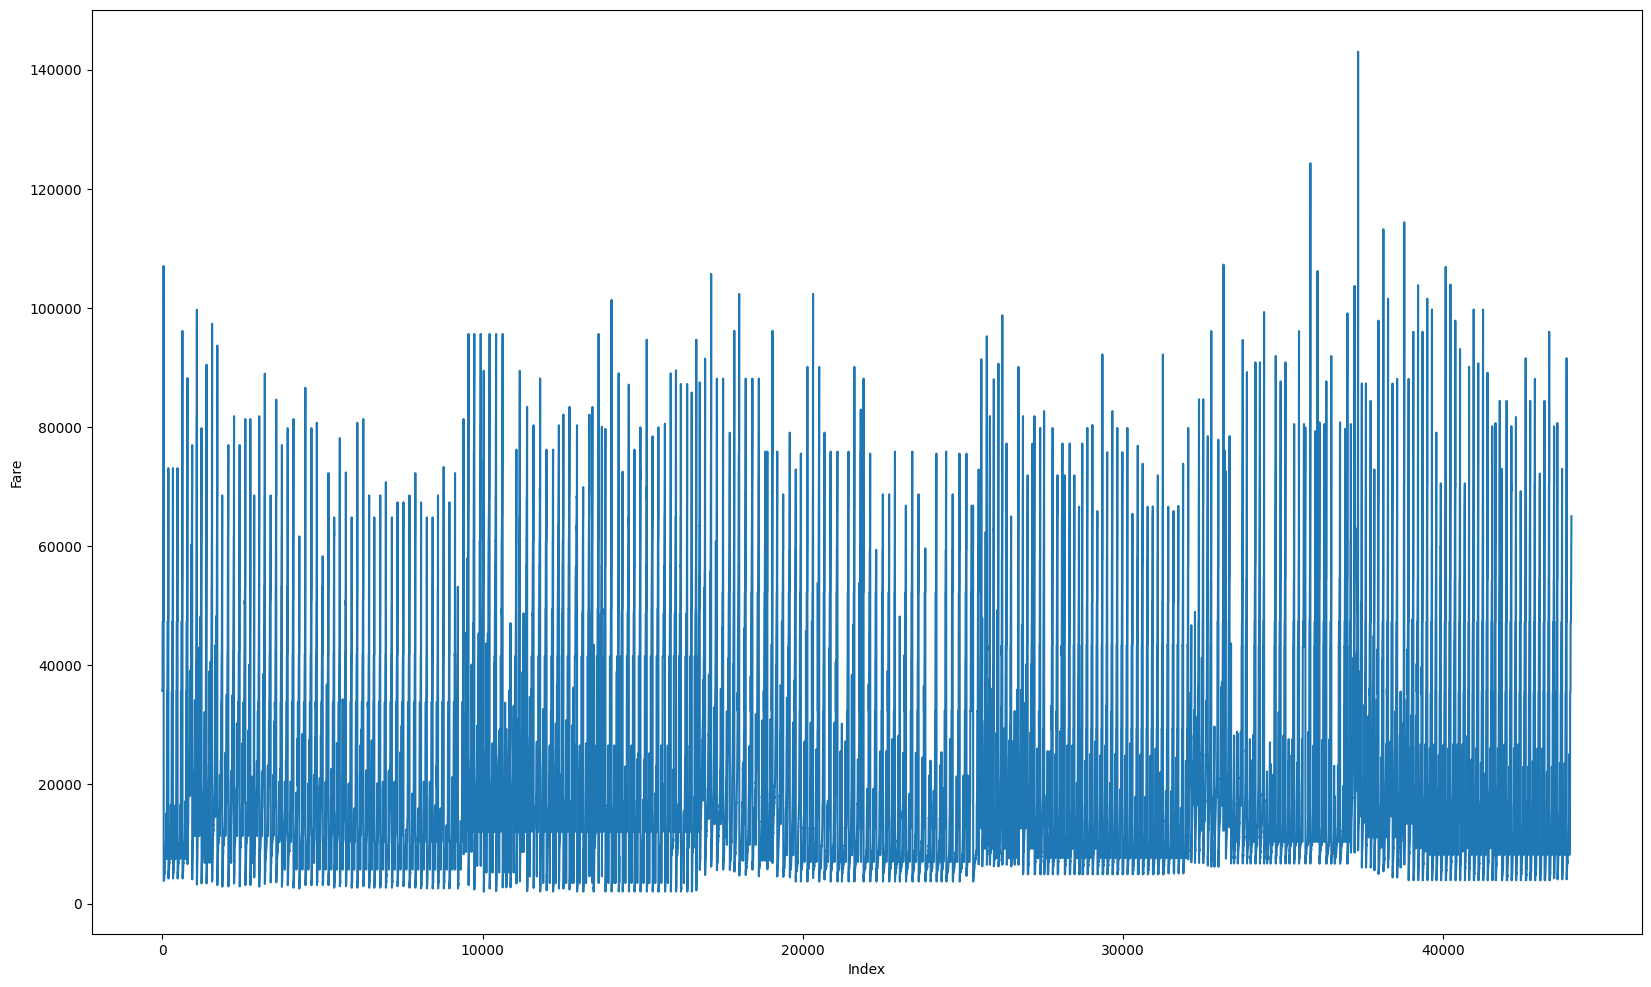

In [9]:
plt.figure(figsize=(20, 12))
plt.plot(all_targets, label='Actual Fare')
plt.xlabel('Index')
plt.ylabel('Fare')
plt.show()

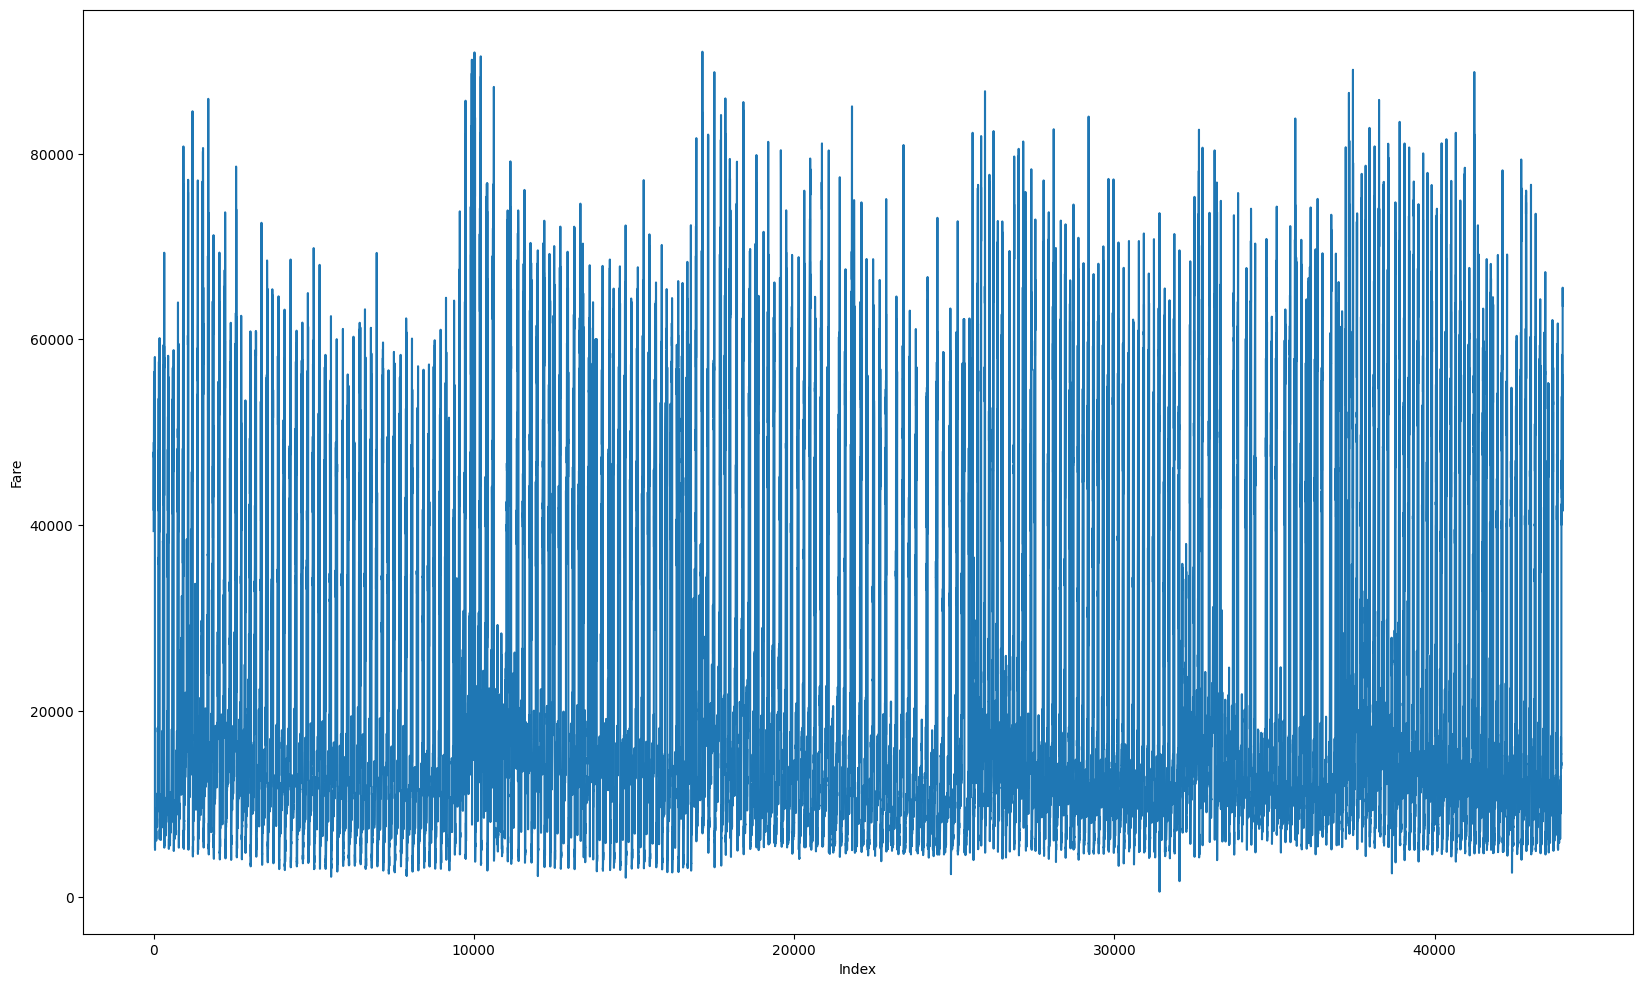

In [10]:
plt.figure(figsize=(20, 12))
plt.plot(all_predictions, label='Predicted Fare')
plt.xlabel('Index')
plt.ylabel('Fare')
plt.show()

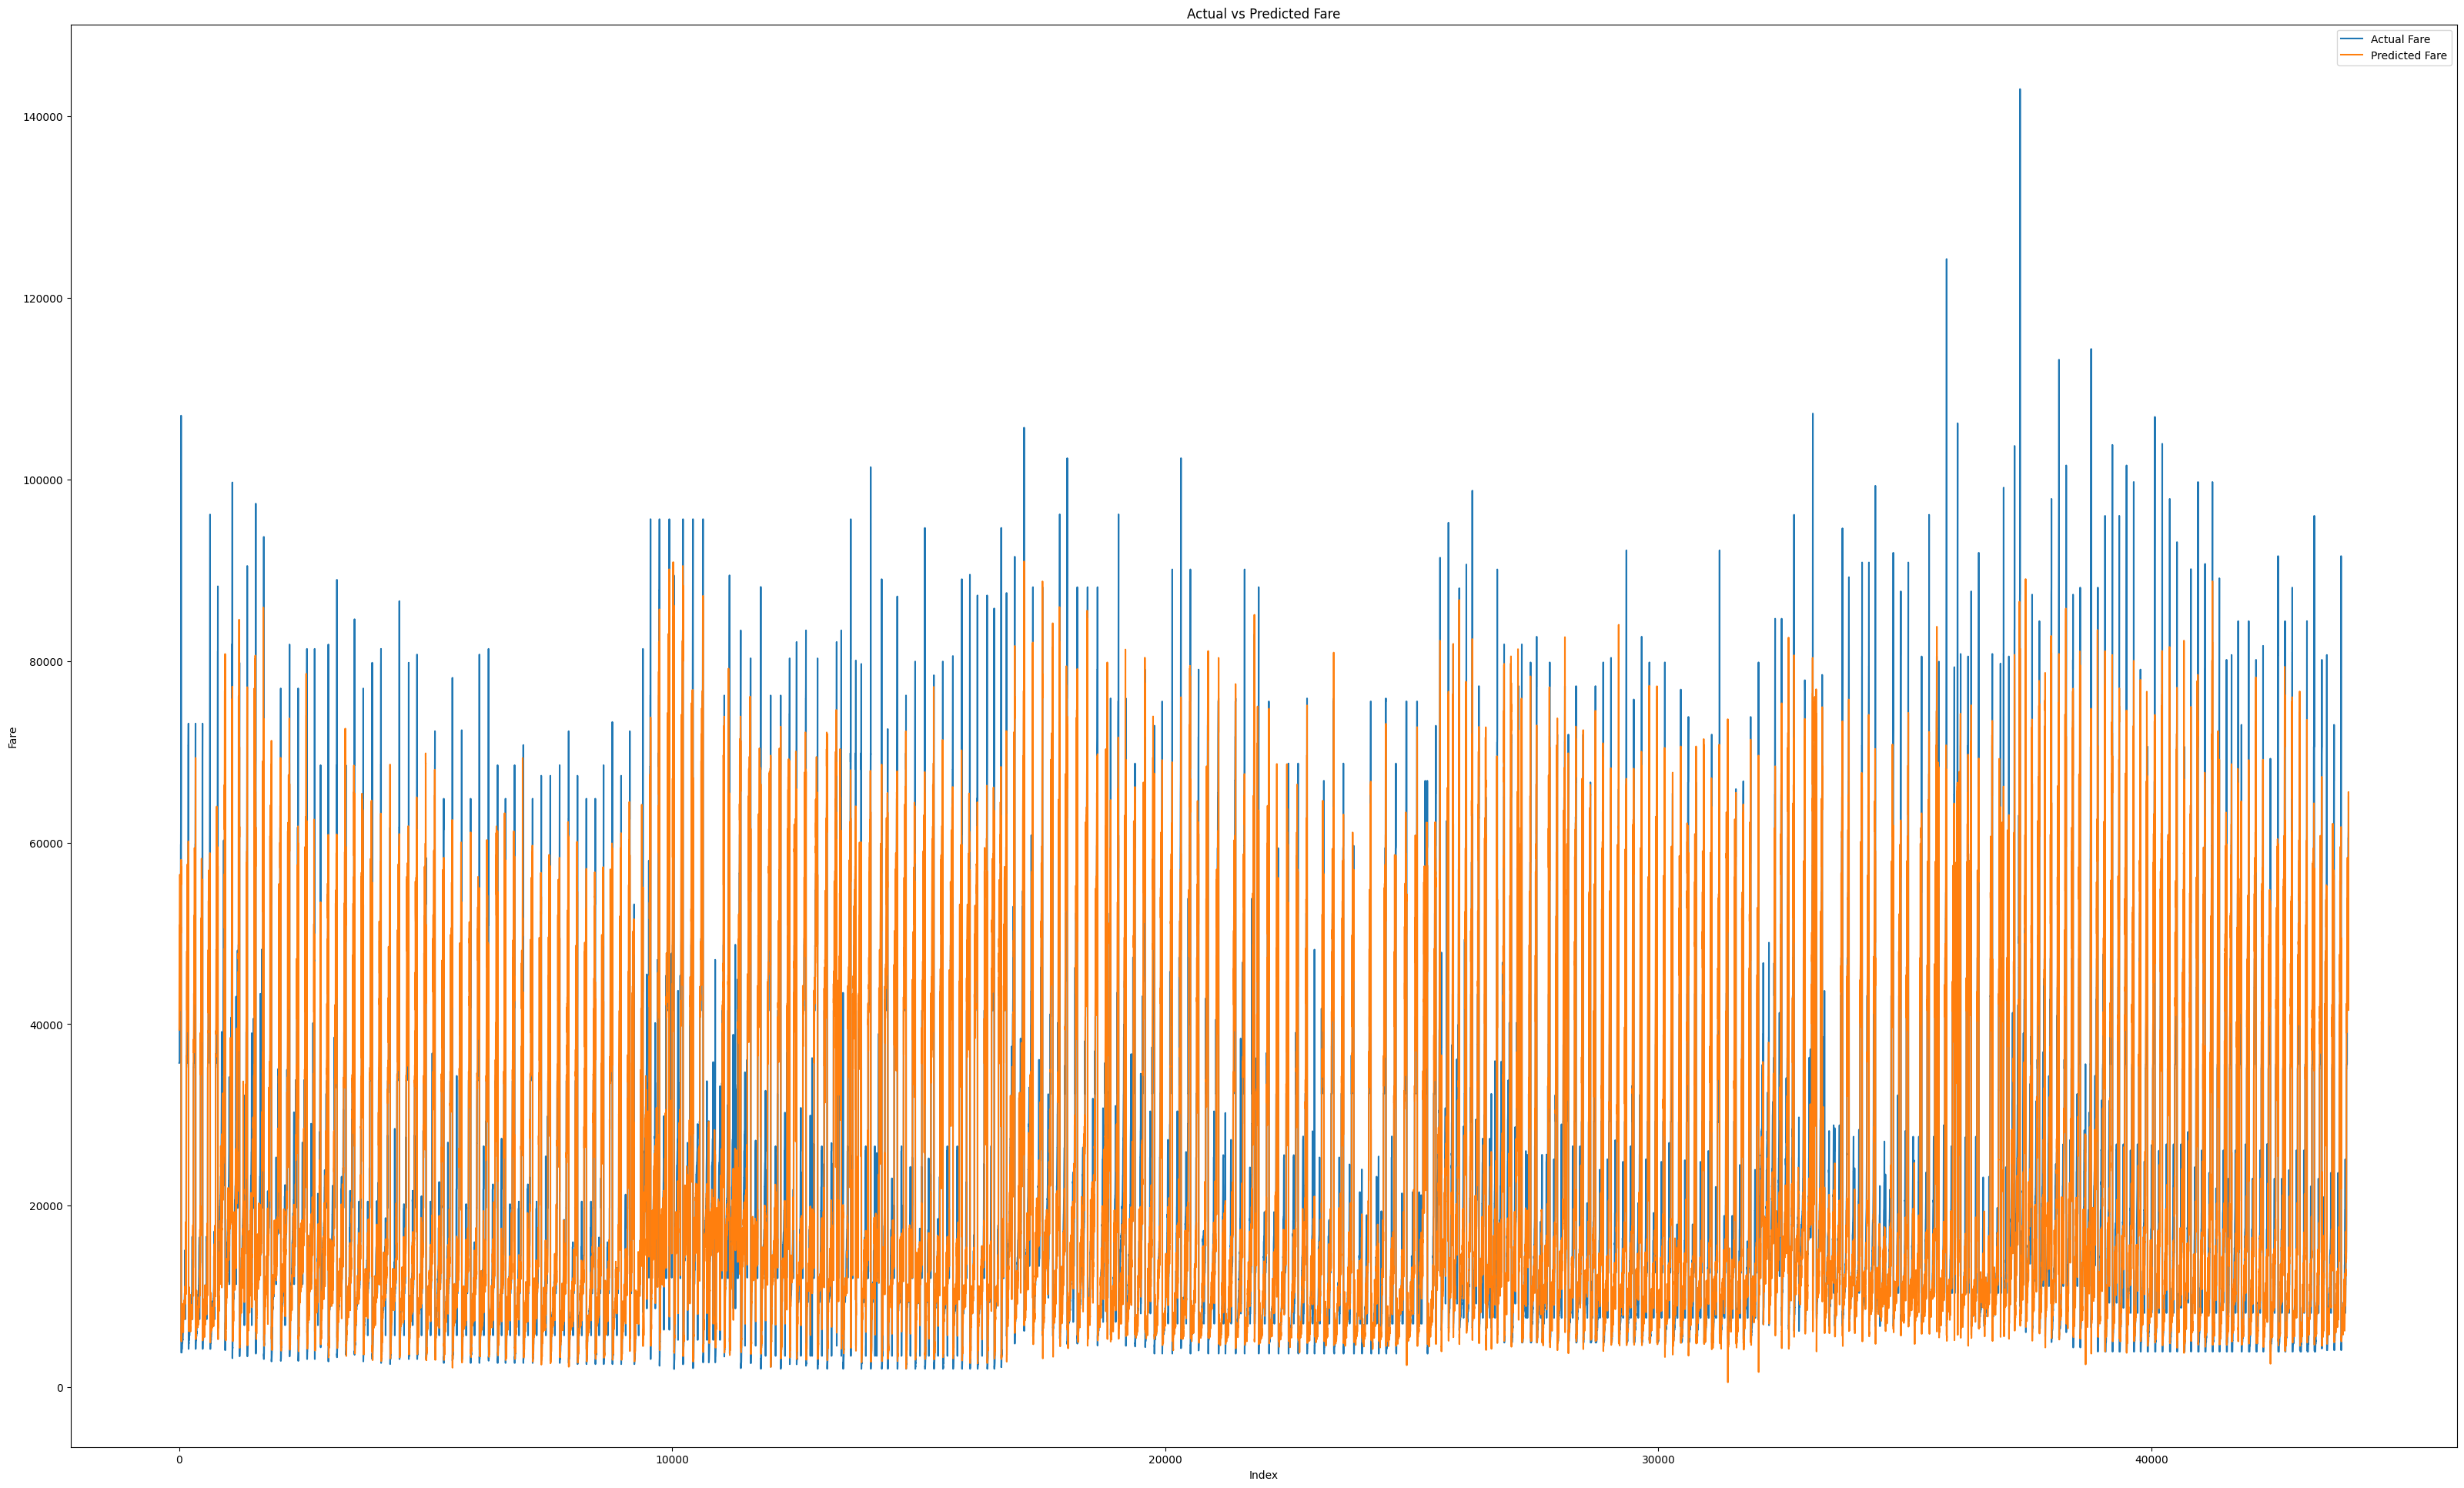

In [11]:
plt.figure(figsize=(40, 24))
plt.plot(all_targets, label='Actual Fare')
plt.plot(all_predictions, label='Predicted Fare')
plt.xlabel('Index')
plt.ylabel('Fare')
plt.title('Actual vs Predicted Fare')
plt.legend()
plt.show()

In [15]:
print ("Model: ",model)
print("R2 Score: ",r2_score(all_targets, all_predictions))
print("MAPE :",mean_absolute_percentage_error(all_predictions, all_targets))
print("RMSE :",rmse)

Model:  LSTMModel(
  (lstm): LSTM(13, 50, num_layers=4, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
R2 Score:  0.8519364959859111
MAPE : [23.626225]
RMSE : [4997.5527]
